### Create AI - Image Semantic Segmentation Model

UNet is a popular deep learning architecture widely used for semantic segmentation tasks, including the analysis of satellite imagery. Its distinctive U-shaped architecture consists of a contracting path, which captures context and reduces spatial dimensions through convolutional and pooling layers, and an expansive path, which enables precise localization using transposed convolutions. This design allows UNet to effectively handle spatially varying structures in satellite images, making it suitable for applications such as land cover classification, urban development monitoring, and disaster damage assessment. With its ability to learn rich hierarchical features and accurately delineate objects of interest, UNet has become a cornerstone in the field of remote sensing and satellite image analysis.

#### 1. Let's import the Dependencies

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

2024-04-03 12:55:27.082009: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 12:55:27.110554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 12:55:27.592001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
w, h = 256,256
border = 5 

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-03 12:55:36.251238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 12:55:36.276412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 12:55:36.276451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


 Checking the number of image and mask

In [5]:
ids = next(os.walk(r"/home/mjanuadi/UnetDeepLearning/data_train/train"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  280


In [6]:
import glob
train_x = sorted(glob.glob('/home/mjanuadi/UnetDeepLearning/data_train/train/*_image.tif'))
train_y = sorted(glob.glob('/home/mjanuadi/UnetDeepLearning/data_train/train/*_label.tif'))
test_x = sorted(glob.glob('/home/mjanuadi/UnetDeepLearning/data_train/test/*_image.tif'))
test_y = sorted(glob.glob('/home/mjanuadi/UnetDeepLearning/data_train/test/*_label.tif'))

print(len(train_x), len(test_x), len(train_y), len(test_y))

70 30 70 30


#### 2. Prepares image and mask data for deep learning tasks

In [7]:
# converting training image to numpy array
from PIL import Image
train_xx = np.zeros((70, 128, 128, 3))
train_yy = np.zeros((70, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):
  # if i == 1:
  #   break

  img = Image.open(img)
  np_img = np.array(img)
  train_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  train_yy[i] = np_mask

In [8]:
# converting training image to numpy array
test_xx = np.zeros((30, 128, 128, 3))
test_yy = np.zeros((30, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_x, test_y)):

  img = Image.open(img)
  np_img = np.array(img)
  test_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  test_yy[i] = np_mask

#### 4. Visualize Image and Mask

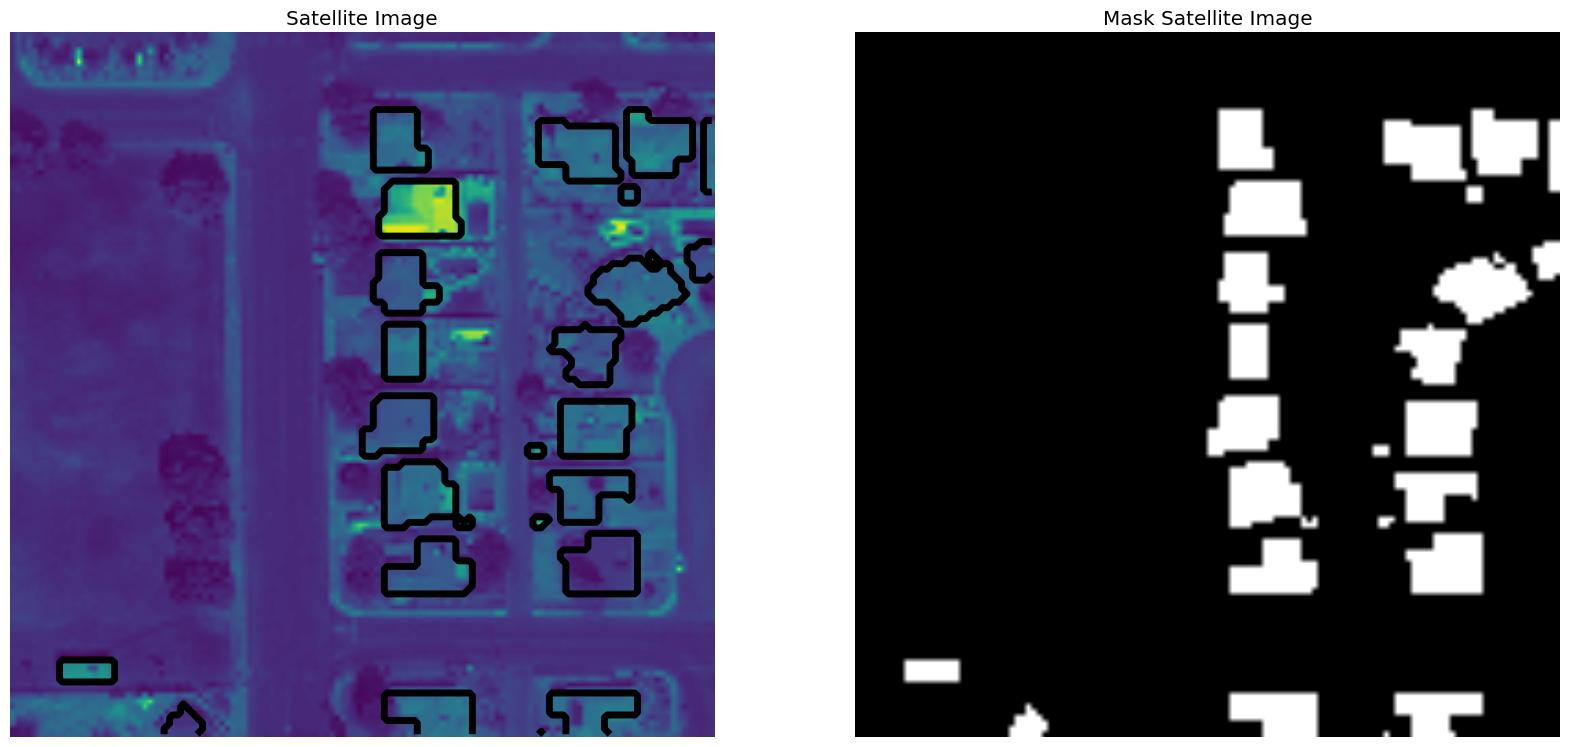

In [11]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(train_xx))
has_mask = train_yy[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(train_xx[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(train_yy[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellite Image')
ax1.set_axis_off()
ax2.imshow(train_yy[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellite Image')
ax2.set_axis_off()

#### 5. Create DenseUnet Model

In [17]:
x_in = Input(shape=(128, 128, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["accuracy"])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d_61[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 64, 64,    │      9,248 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_63[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_65[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_66[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 16, 16,    │     36,928 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_67[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 16, 16,    │     36,928 │ dropout_3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 16, 16,    │     36,928 │ conv2d_68[0][0] 

 Total params: 409,281 (1.56 MB)

 Trainable params: 409,281 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.001, verbose=1),
    ModelCheckpoint('model-DenseUnet.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataDenseUnet_2.csv"),
    TensorBoard(log_dir='./logs')
]
     

In [20]:
results = model.fit(train_xx, train_yy , batch_size=8, epochs=20, callbacks=callbacks, validation_data=(test_xx, test_yy))
     

Epoch 1/20


2024-04-03 13:02:25.272759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:458] Loaded runtime CuDNN library: 8.1.0 but source was compiled with: 8.9.6.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-04-03 13:02:25.512850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:458] Loaded runtime CuDNN library: 8.1.0 but source was compiled with: 8.9.6.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-04-03 13:02:25.527945: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code

  File "/tmp/ipykernel_7931/3250592088.py", line 1, in <module>

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/home/mjanuadi/anaconda3/envs/image-dl/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_35865]

In [23]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('accuracy', ascending=True, inplace = True)
df_result
     

NameError: name 'results' is not defined

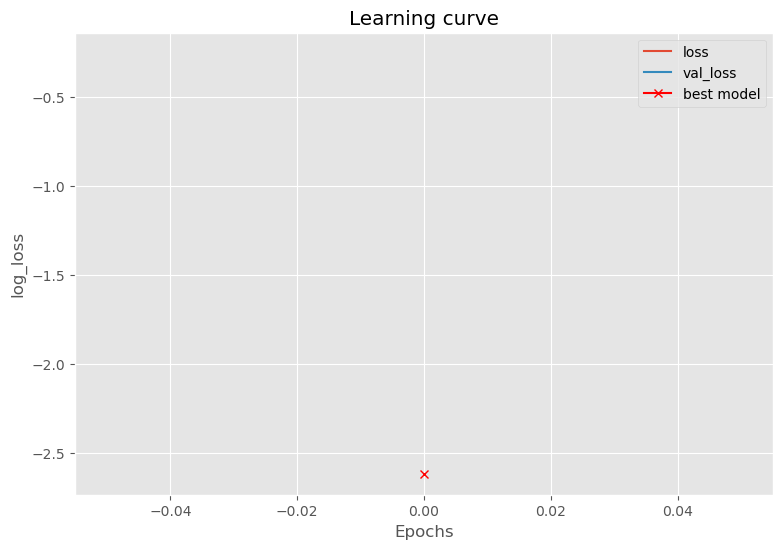

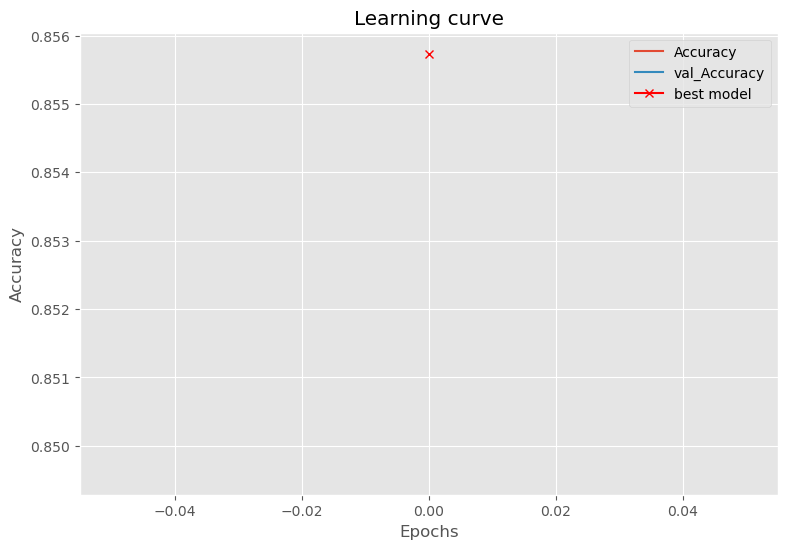

In [ ]:

plt.figure(figsize = (9,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (9,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
     

#### 6. Model Inference
Assess the performance metrics and test the model into a test dataset

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

24/24 [==============================] - 55s 2s/step - loss: -2.6185 - accuracy: 0.8557 - auc: 0.9416 - sensitivity_at_specificity: 0.9899 - specificity_at_sensitivity: 0.9777


[-2.6185495853424072,
 0.855734646320343,
 0.9415842890739441,
 0.9898918271064758,
 0.9777424931526184]

In [ ]:
# Predict on train, val and test
#preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

24/24 [==============================] - 53s 2s/step


In [ ]:
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(preds))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
    ax[0].set_title('RGB Satellite Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Palm Oil Label')
    ax[1].set_axis_off()
    
    ax[2].imshow(preds[ix].squeeze())
    ax[2].set_title('Palm Oil Predicted');
    ax[2].set_axis_off()    

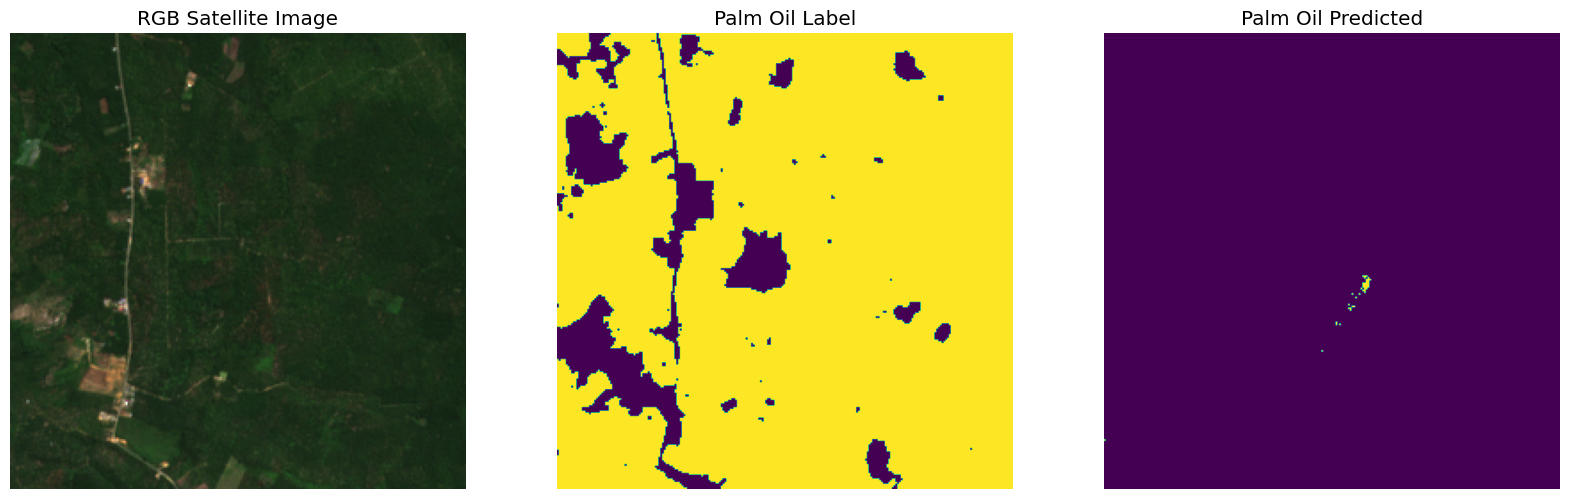

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_val)